# Evaluation of the parametrised model

In [1]:
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from modules import stats


In [2]:
client = Client(n_workers=4, threads_per_worker=1, memory_limit='8GB')
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46439,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:37767,Total threads: 1
Dashboard: http://127.0.0.1:41977/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:38473,


In [3]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/05_evaluation/'
# data_path = base_path + 'final_data/evaluation/'
data_path = base_path + 'final_data/resolution_tests/'
config_file = base_path + 'config/resolution_tests_low.yml'

with open(config_file, 'r') as f:
    config = yaml.load(f, yaml.Loader)

RAYLEIGH = config['base']['parameters']['rayleigh']
PRANDTL = config['base']['parameters']['prandtl']
FINE_INIT_TIME = 650.
SPIN_UP_TIME = 750.
AVG_TIME = 150.


In [5]:
data = {}
data['truth'] = xr.open_mfdataset(
    data_path + '2048x256/*.nc', chunks = {'x': -1, 'z': -1, 't': 25},
)
data['truth']['t'] = data['truth']['t'] + FINE_INIT_TIME
data['control'] = xr.open_mfdataset(
    data_path + '256x64/*.nc', chunks = {'x': -1, 'z': -1, 't': 800},
)
data['test'] = xr.open_mfdataset(
    data_path + '512x64/*.nc', chunks = {'x': -1, 'z': -1, 't': 400},
)

for run in data:
    data[run] = data[run].isel(t=(data[run].t >= SPIN_UP_TIME))


In [6]:
nusselt = {}
rms_speed = {}
eps_k = {}
eps_T = {}
for run in data:
    nusselt[run] = stats.nusselt_number(
        data[run], RAYLEIGH, PRANDTL).compute()
    rms_speed[run] = stats.rms_speed(data[run]).compute()
    eps_k[run] = stats.kinetic_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()
    eps_T[run] = stats.thermal_dissipation(
        data[run], RAYLEIGH, PRANDTL).compute()


In [7]:
metrics = {
    r'$\mathrm{Nu}$': nusselt,
    r'$u_\mathrm{rms}$': rms_speed,
    r'$\epsilon_k$': eps_k,
    r'$\epsilon_T$': eps_T,
}


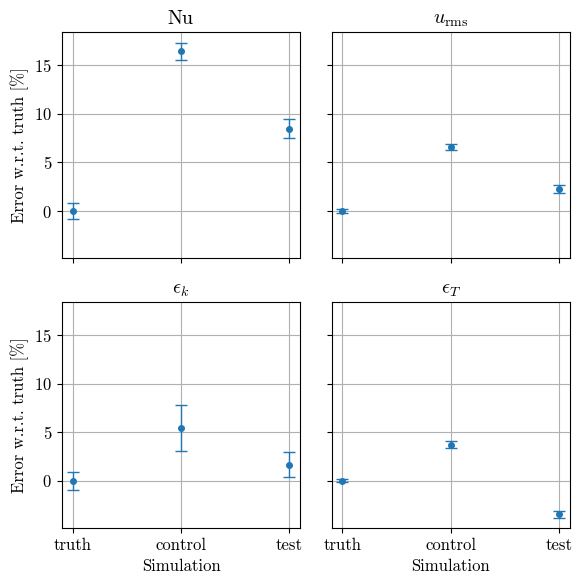

In [14]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))

for ax, (name, var) in zip(axes.ravel(), metrics.items()):
    mean_truth, delta_truth = stats.mean_and_uncertainty(
        var['truth'], 't', AVG_TIME,
    )
    means = []
    deltas = []
    for run in var:
        mean, delta = stats.mean_and_uncertainty(var[run], 't', AVG_TIME)
        means.append((mean/mean_truth - 1)*100)
        deltas.append(delta/mean_truth*100)

    ax.errorbar(
        list(var.keys()), means, yerr=deltas,
        capsize=4, elinewidth=1, marker='.', linestyle='',
        capthick=1, markersize=8,
    )
    ax.set_title(name)
    ax.grid()

for ax in axes[-1,:]: ax.set_xlabel('Simulation')

for ax in axes[:,0]: ax.set_ylabel(
    f'Error w.r.t. truth [%]')

fig.tight_layout()
# fig.savefig(fig_path + 'resolution_dependence.pdf')


In [23]:
client.close()
